<a href="https://colab.research.google.com/github/Lagc93/Procesamiento-Digital-De-Senales/blob/main/TAREA_1_PROCESAMIENTO_DIGITAL_DE_SE%C3%91ALES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **PROCESAMIENTO DIGITAL DE SEÑALES**



**ESTUDIANTE:** Luis Ausberto Guerrero Caicedo

**¿Como se calcula Fourier cuando las muestras no están uniformemente muestreadas?**

Cuando las muestras no están uniformemente espaciadas en el tiempo (muestreo no uniforme), no se puede aplicar directamente la Transformada Discreta de Fourier (DFT) o su versión computacional (la FFT), ya que estas suponen un muestreo equidistante. Sin embargo, existen variantes y modelos que permiten hacer análisis en frecuencia sobre datos no uniformemente muestreados.








**1. NDFT (Non-Uniform Discrete Fourier Transform):**

La NDFT es una extensión de la Discrete Fourier Transform (DFT) que permite el análisis espectral de señales muestreadas en tiempos no uniformemente espaciados. La DFT tradicional supone que las muestras se obtienen en intervalos constantes, pero en muchas aplicaciones prácticas, como en astronomía o procesamiento de señales de audio, las muestras no están espaciadas uniformemente. La NDFT resuelve este problema permitiendo que las muestras estén ubicadas en tiempos arbitrarios.

La expresión de la NDFT para una señal $x(t_n)$  tomada en los puntos $t_n$ es:

$$ X(f) = \sum_{n=0}^{N-1} x(t_n) \cdot e^{-j 2\pi f t_n} $$

Donde:

*  $ t_n $ son los tiempos no uniformes en los cuales se toma la señal $ x(t) $

* $ f $ es la frecuencia en la cual se evalúa la transformada,

*  $ j $ es la unidad imaginaria.

Propiedades:


* Es útil cuando no se tiene acceso a un muestreo uniforme de la señal.  

*  La NDFT no se puede calcular eficientemente utilizando la FFT, por lo que el tiempo de cómputo crece con el número de muestras
N y frecuencias M

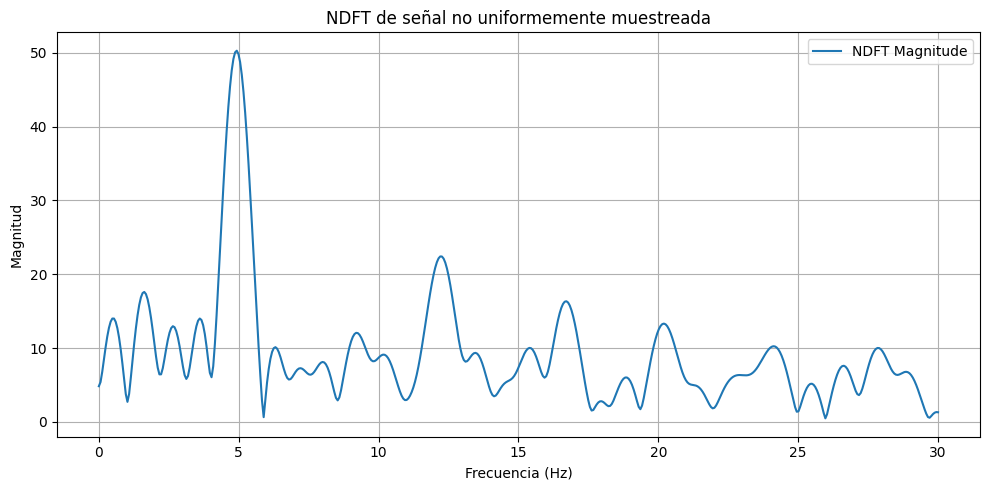

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generar tiempos no uniformes
N = 100
t_nonuniform = np.sort(np.random.rand(N))  # tiempos entre 0 y 1 no uniformes

# 2. Crear una señal: por ejemplo, una suma de senos
f1, f2 = 5, 12  # frecuencias en Hz
signal = np.sin(2 * np.pi * f1 * t_nonuniform) + 0.5 * np.sin(2 * np.pi * f2 * t_nonuniform)

# 3. Definir las frecuencias en las que se evaluará la NDFT
num_freqs = 500
frequencies = np.linspace(0, 30, num_freqs)

# 4. Implementación de la NDFT
def ndft(t, x, freqs):
    X = np.zeros_like(freqs, dtype=complex)
    for i, f in enumerate(freqs):
        X[i] = np.sum(x * np.exp(-1j * 2 * np.pi * f * t))
    return X

# 5. Calcular NDFT
ndft_result = ndft(t_nonuniform, signal, frequencies)

# 6. Graficar resultados
plt.figure(figsize=(10, 5))
plt.plot(frequencies, np.abs(ndft_result), label='NDFT Magnitude')
plt.title('NDFT de señal no uniformemente muestreada')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**2. NUFFT (Non-Uniform Fast Fourier Transform):**

La NUFFT es una generalización eficiente de la NDFT que utiliza un enfoque basado en interpolaciones rápidas y transformadas de Fourier rápidas (FFT). Esta técnica optimiza el cálculo de la NDFT utilizando una rejilla uniforme de frecuencias, mejorando drásticamente la velocidad de cálculo.

El cálculo de la NUFFT involucra los siguientes pasos:

1. Interpolación de la señal muestreada no uniformemente en una malla uniforme de puntos.

2. Aplicación de la FFT a la señal interpolada.
3. Recálculo de la transformada en los puntos de frecuencia deseados.

El espectro resultante se aproxima de la siguiente manera:


$$
X(f_k) \approx \sum_{n=0}^{N-1} x(t_n) e^{-j 2\pi f_k t_n}
$$

Donde $ f_k $ son las frecuencias a las cuales se calcula la transformada.

**Ventajas:**

* Computacionalmente eficiente, con una complejidad de $  \mathcal{O}(N \log N)  $

* Capaz de tratar señales no uniformemente muestreadas con alta precisión.

**Desventajas:**

* Requiere una implementación más compleja y dependencias adicionales (como la biblioteca finufft).



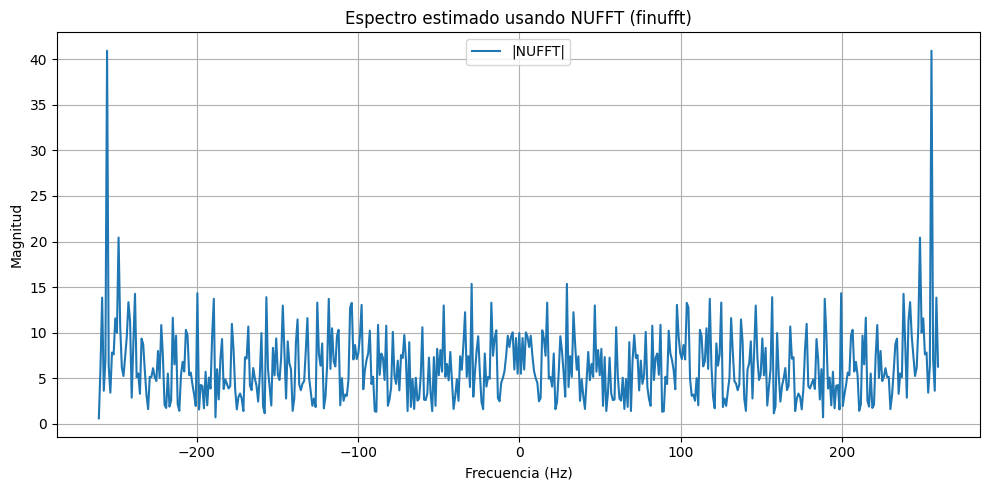

In [27]:
!pip install finufft
import finufft

# 1. Generar tiempos no uniformes ordenados
N = 100
t_nonuniform = np.sort(np.random.rand(N))  # tiempos entre 0 y 1

# 2. Crear señal con dos frecuencias
f1, f2 = 5, 12  # Hz
signal = np.sin(2 * np.pi * f1 * t_nonuniform) + 0.5 * np.sin(2 * np.pi * f2 * t_nonuniform)

# 3. Escalar los tiempos a [-pi, pi] como requiere finufft
xj = 2 * np.pi * (t_nonuniform - 0.5)

# 4. Definir cantidad de frecuencias a analizar
ms = 512
frequencies = np.arange(-ms//2, ms//2)

# 5. Aplicar NUFFT tipo 1: tiempos no uniformes -> frecuencias uniformes
# Usamos n_modes=(ms,) como espera la API de finufft
Xk = finufft.nufft1d1(xj, signal.astype(np.complex128), n_modes=(ms,), eps=1e-12)

# 6. Transformar a Hz
delta_t = t_nonuniform[-1] - t_nonuniform[0]
freqs_hz = frequencies / delta_t

# 7. Graficar el espectro
plt.figure(figsize=(10, 5))
plt.plot(freqs_hz, np.abs(np.fft.fftshift(Xk)), label='|NUFFT|')
plt.title('Espectro estimado usando NUFFT (finufft)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**3. Interpolación + FFT:**

Este método consiste en interpolar la señal no uniformemente muestreada a una malla de tiempos uniformemente espaciados y luego aplicar la FFT para obtener el espectro. La idea es utilizar herramientas estándar (como la FFT) que son rápidas y eficientes para señales uniformemente muestreadas.

**Proceso:**

1. La señal se interpola en una malla de tiempo uniforme $t_k $ utilizando un método de interpolación (por ejemplo, interpolación cúbica).

2.  Se realiza la FFT sobre los datos interpolados para obtener el espectro.

La señal interpolada $  \hat{x}(t_k)  $ se obtiene mediante:

$$
\hat{x}(t_k) = \sum_{n=0}^{N-1} x(t_n) \cdot \mathcal{I}(t_k, t_n)
$$

Donde $  \mathcal{I}(t_k, t_n)  $ es la función de interpolación que calcula el valor interpolado en el tiempo $  t_k $.

**Ventajas:**

* La implementación es sencilla y se puede aprovechar la eficiencia de la FFT.

* Permite obtener resultados rápidos cuando la interpolación se hace adecuadamente.

**Desventajas:**

* La precisión depende en gran medida de la calidad de la interpolación y del espaciamiento temporal de las muestras.



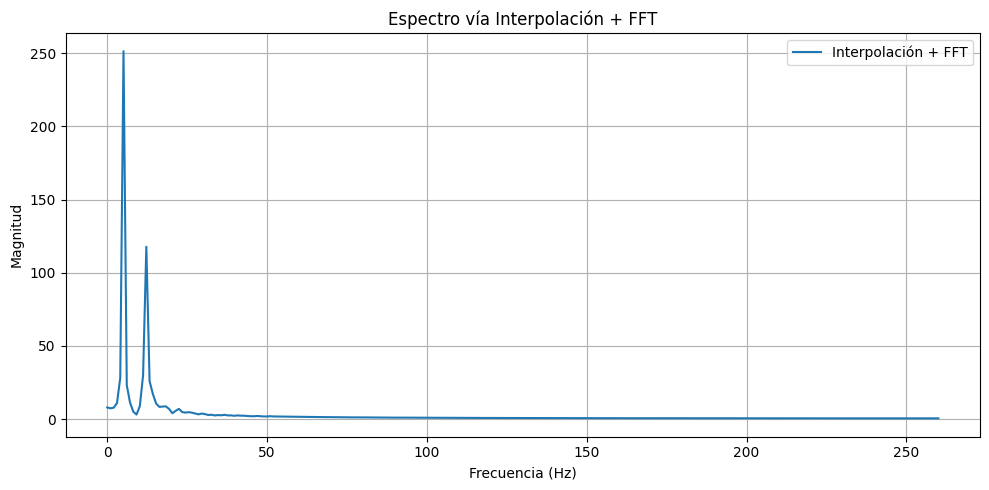

In [28]:
from scipy.interpolate import interp1d

# 1. Crear tiempos no uniformes
N = 100
t_nonuniform = np.sort(np.random.rand(N))  # tiempos entre 0 y 1

# 2. Señal original (suma de senos)
f1, f2 = 5, 12
signal = np.sin(2 * np.pi * f1 * t_nonuniform) + 0.5 * np.sin(2 * np.pi * f2 * t_nonuniform)

# 3. Crear una rejilla de tiempo uniforme para interpolar
M = 512
t_uniform = np.linspace(t_nonuniform[0], t_nonuniform[-1], M)

# 4. Interpolación (cúbica)
interpolator = interp1d(t_nonuniform, signal, kind='cubic')
signal_uniform = interpolator(t_uniform)

# 5. Aplicar FFT
fft_result = np.fft.fft(signal_uniform)
frequencies = np.fft.fftfreq(M, d=(t_uniform[1] - t_uniform[0]))

# 6. Graficar espectro
plt.figure(figsize=(10, 5))
plt.plot(frequencies[:M//2], np.abs(fft_result[:M//2]), label='Interpolación + FFT')
plt.title('Espectro vía Interpolación + FFT')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**4. Ajuste por Mínimos Cuadrados:**

El método de ajuste por mínimos cuadrados para estimación espectral se basa en aproximar una señal como una combinación lineal de funciones seno y coseno, es decir, de forma armónica. El objetivo es estimar los coeficientes de estas funciones (frecuencias, amplitudes y fases) que mejor describen la señal muestreada.

Proceso: Dada una señal $ x_t $ muestreada en $ t_n $ el modelo es:

$$
x(t) \approx \sum_{k=1}^{K} \left( a_k \cos(2\pi f_k t) + b_k \sin(2\pi f_k t) \right)
$$

El problema es resolver el sistema de ecuaciones:

$$
\mathbf{x} = \mathbf{A} \cdot \mathbf{c}
$$

Donde:

* $\ \mathbf{A}  $ es una matriz cuyas columnas contienen funciones seno y coseno para cada frecuencia $ f_k $,

*  $ \mathbf{c} $ es el vector de coeficientes $ [a_1, b_1, a_2, b_2, \dots] $.

Se obtiene la mejor estimación de $ \mathbf{c} $ utilizando el método de mínimos cuadrados, que busca minimizar la diferencia entre la señal estimada y la señal real:

$$
\min_{\mathbf{c}} \| \mathbf{A} \cdot \mathbf{c} - \mathbf{x} \|^2
$$

**Ventajas:**

* Este método proporciona una descomposición precisa de la señal en frecuencias.

* Es particularmente útil cuando se tienen señales con múltiples componentes de frecuencia.

**Desventajas:**

* Es costoso computacionalmente, especialmente cuando el número de frecuencias es alto.

* Puede ser sensible al ruido si la señal no está suficientemente bien muestreada.


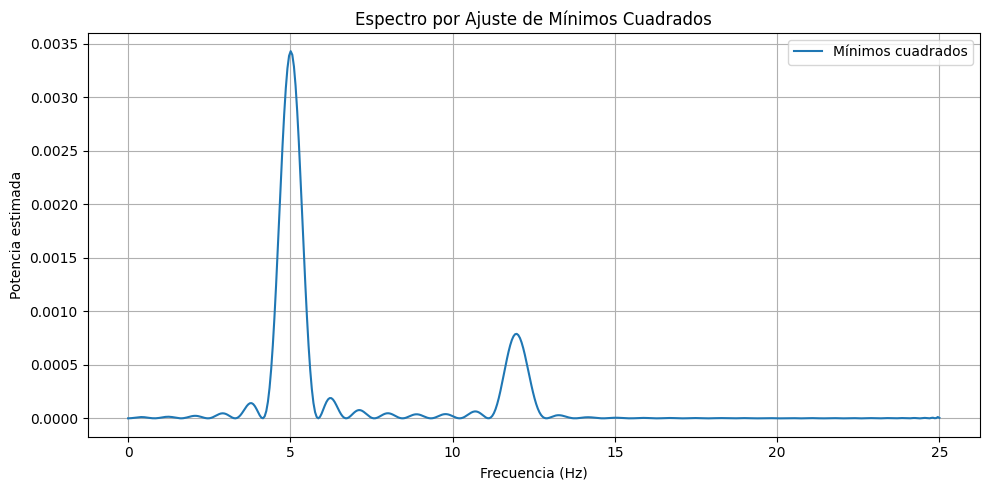

In [29]:

# 1. Generar tiempos no uniformes
N = 100
t_nonuniform = np.sort(np.random.rand(N))  # en segundos

# 2. Señal con dos frecuencias
f1, f2 = 5, 12  # Hz
signal = np.sin(2 * np.pi * f1 * t_nonuniform) + 0.5 * np.sin(2 * np.pi * f2 * t_nonuniform)

# 3. Conjunto de frecuencias que evaluaremos
num_freqs = 500
frequencies = np.linspace(0, 25, num_freqs)  # en Hz

# 4. Construir la matriz del modelo: [cos(2πft)  sin(2πft)]
A = np.column_stack([
    np.cos(2 * np.pi * f * t_nonuniform) for f in frequencies
] + [
    np.sin(2 * np.pi * f * t_nonuniform) for f in frequencies
])

# 5. Resolver el sistema por mínimos cuadrados
coeffs, _, _, _ = np.linalg.lstsq(A, signal, rcond=None)

# 6. Calcular potencia espectral (suma de cuadrados de cos y sin)
power = coeffs[:num_freqs]**2 + coeffs[num_freqs:]**2

# 7. Graficar
plt.figure(figsize=(10, 5))
plt.plot(frequencies, power, label='Mínimos cuadrados')
plt.title('Espectro por Ajuste de Mínimos Cuadrados')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia estimada')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
